<a href="https://colab.research.google.com/github/burrows99/NLP_Project/blob/main/NLP_Project_(Experiment_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Install and upgrade core dependencies**

The following cell ensures you have the latest versions of the key libraries used in this notebook:

In [ ]:
%pip install --upgrade \
  datasets \
  fsspec \
  transformers \
  sklearn-crfsuite \
  seqeval \
  pandas \
  gradio==3.45 \
  joblib \
  evaluate \
  fastapi \
  uvicorn

  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)


**2. Import all necessary libraries and modules**

This cell sets up the full environment by importing all core libraries required for preprocessing, modeling, evaluation, and interaction:

---

🔹 **System and Utility**  
- `os`, `time`, `json`: File handling, logging, and timing operations  
- `logging`: For structured console/debug logging

🔹 **Numerical & Data Manipulation**  
- `numpy`, `pandas`: Efficient data handling and manipulation  
- `matplotlib.pyplot`: Visualization (e.g., F1 scores, confusion matrix)

🔹 **PyTorch**  
- `torch`, `nn`: For potential deep learning models

🔹 **NLTK (Natural Language Toolkit)**  
- `nltk`, `pos_tag`, `PorterStemmer`, `ngrams`: Tokenization, stemming, n-gram generation

🔹 **Gradio**  
- `gr`: UI component for interactive demos

🔹 **Hugging Face Datasets**  
- `load_dataset`: Load prebuilt datasets (like CoNLL-2003, etc.)

🔹 **scikit-learn & sklearn-crfsuite**  
- `FeatureHasher`, `train_test_split`: Hashing & splitting utilities  
- `CRF`, `metrics`, `flat_classification_report`, `flatten`: CRF modeling and evaluation

🔹 **Hugging Face Transformers**  
- `AutoTokenizer`, `AutoModelForTokenClassification`: Pretrained transformer models for token-level tasks  
- `TrainingArguments`, `Trainer`: Training utilities for fine-tuning models

🔹 **Colab Drive**  
- `google.colab.drive`: Mount and use Google Drive for persistent storage

🔹 **SeqEval**  
- `classification_report`: Evaluation metrics tailored for sequence labeling (NER, POS tagging, etc.)

🔹 **Joblib**  
- `joblib`: Efficient model serialization/deserialization


In [ ]:
# Standard library imports
import os
import time
import json
import logging
from collections import defaultdict

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from datasets import load_dataset
import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    BertTokenizerFast,
    BertForTokenClassification,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
    get_scheduler
)
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split
from sklearn_crfsuite import CRF, metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn_crfsuite.utils import flatten
import joblib
import gradio as gr
from tqdm.auto import tqdm
import nltk
from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk.util import ngrams
from seqeval.metrics import classification_report

# Local application imports
from google.colab import drive


**3. Setup NLTK and Mount Google Drive**

---

🔹 **NLTK Resource Setup**  
Before processing text, we ensure that essential NLTK resources are available locally:

- `'punkt'`: Tokenizer for sentence and word splitting  
- `'averaged_perceptron_tagger'` & `'averaged_perceptron_tagger_eng'`: Part-of-speech taggers

Each resource is checked and downloaded only if missing, ensuring a reproducible environment without redundant downloads.

```python
for res in ['averaged_perceptron_tagger', 'averaged_perceptron_tagger_eng', 'punkt']:
    try:
        nltk.data.find(f'taggers/{res}')
    except LookupError:
        nltk.download(res)
```

💾 **Safe Google Drive Mount (Clean Remount)**  
To avoid ValueError due to existing files in /content/drive, we:
- Forcefully remove any previous or corrupted mount point.
- Perform a clean remount of Google Drive using force_remount=True.

```python
!rm -rf /content/drive
drive.mount('/content/drive', force_remount=True)
```


In [ ]:
# 1. Imports and NLTK setup
for res in ['averaged_perceptron_tagger', 'averaged_perceptron_tagger_eng', 'punkt']:
    try:
        nltk.data.find(f'taggers/{res}')
    except LookupError:
        nltk.download(res)

# 2. Clean any stale mount and remount Google Drive
!rm -rf /content/drive
drive.mount('/content/drive', force_remount=True)

rm: cannot remove '/content/drive/.file-revisions-by-id': Operation canceled
rm: cannot remove '/content/drive/MyDrive': Operation canceled
rm: cannot remove '/content/drive/.shortcut-targets-by-id': Operation canceled
rm: cannot remove '/content/drive/.Trash-0': Directory not empty
rm: cannot remove '/content/drive/.Encrypted/MyDrive': Operation canceled
rm: cannot remove '/content/drive/.Encrypted/.shortcut-targets-by-id': Operation canceled


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Mounted at /content/drive


### ⚙️ CRF Utilities and Pipeline Setup

This cell defines a comprehensive suite of utility functions to **train, evaluate, and manage a CRF (Conditional Random Field) model**, along with feature extraction and structured logging.

---

#### 🧠 Key Components:

- **🔗 Model Path & Logging**
  - `MODEL_PATH`: Predefined path on Google Drive for saving the best CRF model.
  - Python's `logging` module is configured for detailed, timestamped logging.

- **💾 Model Saving & Loading**
  - `save_model(...)`: Serializes and stores the CRF model using `joblib`.
  - `load_model(...)`: Loads a saved CRF model from disk.
  - `ensure_dir_exists(...)`: Ensures the directory structure for model persistence exists.

- **📊 Training & Evaluation**
  - `train_crf_model(...)`: Fits the CRF model on training data.
  - `evaluate_model(...)`: Uses `seqeval` to generate classification reports for model performance.

- **📈 Visualization**
  - `plot_f1_scores(...)`: Visualizes F1-score distribution across tags using `matplotlib`.

- **✅ Data Validation**
  - `validate_data_shapes(...)`: Ensures input features and labels align before training.

---

#### 🧪 Feature Engineering:

A modular set of feature functions used to transform tokenized text into CRF-suitable features:

- `get_word_features`: Lowercased form, stem, and word length  
- `get_ngram_features`: Includes bigram and trigram context  
- `get_context_features`: Previous and next word context  
- `get_orthographic_features`: Capitalization, digits, hyphens, prefixes/suffixes  
- `extract_common_features`: Aggregates all the above into a final token-level feature set

---

#### 🚀 Main Pipeline:

- `run_crf_pipeline(...)`: End-to-end execution pipeline for:
  1. Feature extraction
  2. Data validation
  3. Model training
  4. Model saving
  5. Evaluation on validation & test sets
  6. F1 visualization

Use this modular structure to support flexible experimentation with different feature sets or model hyperparameters.


In [ ]:
LOG_PATH   = '/content/drive/MyDrive/logs/predictions.jsonl'

CRF1_MODEL_PATH = '/content/drive/MyDrive/models/crf1_model.joblib'
CRF2_MODEL_PATH = '/content/drive/MyDrive/models/crf2_model.joblib'
BERT_MODEL_PATH = '/content/drive/MyDrive/models/bert_model.joblib'

# Setup logger for detailed traceability
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

stemmer = PorterStemmer()

def print_section_separator():
    print("=" * 50)

def ensure_dir_exists(path):
    """Ensure the directory for a given path exists."""
    directory = os.path.dirname(path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        logger.info(f"Created directory: {directory}")
    else:
        logger.debug(f"Directory already exists: {directory}")


def save_model(model, model_path):
    """Save the trained model to disk."""
    try:
        ensure_dir_exists(model_path)
        joblib.dump(model, model_path)
        logger.info(f"Model saved successfully at: {model_path}")
    except Exception as e:
        logger.error(f"Error saving model: {e}")
        raise

def load_model(model_path):
    """Load a saved CRF model."""
    try:
        model = joblib.load(model_path)
        logger.info(f"Model loaded from: {model_path}")
        return model
    except Exception as e:
        logger.error(f"Error loading model: {e}")
        raise


def extract_features(featurizer_func, tokens_list):
    """Apply featurizer function on list of token sequences."""
    logger.info(f"Extracting features for {len(tokens_list)} sequences.")
    try:
        return [featurizer_func(sentence) for sentence in tokens_list]
    except Exception as e:
        logger.error(f"Feature extraction failed: {e}")
        raise


def train_crf_model(crf_model, X_train, y_train):
    """Train the CRF model."""
    logger.info(f"Training CRF model on {len(X_train)} samples.")
    try:
        crf_model.fit(X_train, y_train)
        logger.info("CRF training completed.")
        return crf_model
    except Exception as e:
        logger.error(f"Training failed: {e}")
        raise


def evaluate_model(crf_model, X_eval, y_true, dataset_name="Evaluation"):
    """Evaluate the model and print classification report."""
    logger.info(f"Evaluating model on {dataset_name} set with {len(X_eval)} samples.")
    try:
        y_pred = crf_model.predict(X_eval)
        report = classification_report(y_true, y_pred)
        print(f"\n=== {dataset_name} Set Classification Report ===")
        print(report)
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        logger.info(f"{dataset_name} evaluation completed.")
        return report_dict
    except Exception as e:
        logger.error(f"Evaluation failed: {e}")
        raise


def plot_f1_scores(report_dict, variation_name):
    """Plot F1 scores for each label from the classification report."""
    labels, f1_scores = [], []
    for label, metrics in report_dict.items():
        if label not in ("accuracy", "macro avg", "weighted avg"):
            labels.append(label)
            f1_scores.append(metrics.get("f1-score", 0.0))

    if not labels:
        logger.warning("No labels found to plot F1 scores.")
        return

    logger.info(f"Plotting F1 scores for variation: {variation_name}")
    x = np.arange(len(labels))
    plt.figure(figsize=(10, 5))
    plt.bar(x, f1_scores, color='skyblue')
    plt.xticks(x, labels, rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.title(f'F1 Scores per Label - {variation_name}')
    plt.ylabel('F1 Score')
    plt.tight_layout()
    plt.show()


def validate_data_shapes(X, y, dataset_name):
    if len(X) != len(y):
        message = f"{dataset_name} feature/label length mismatch: {len(X)} vs {len(y)}"
        logger.error(message)
        raise ValueError(message)
    logger.info(f"{dataset_name} data shape validation passed.")


def run_crf_pipeline(
    featurizer_func,
    crf_model,
    dataset,
    train_data,
    val_data,
    test_data,
    model_path,
    variation_name="Unnamed Variation"
):
    """
    Runs a CRF training and evaluation pipeline.
    """

    logger.info(f"Starting CRF pipeline for: {variation_name}")

    train_tokens, train_tags = train_data
    val_tokens, val_tags = val_data
    test_tokens, test_tags = test_data

    # Feature extraction
    X_train = extract_features(featurizer_func, train_tokens)
    X_val = extract_features(featurizer_func, val_tokens)
    X_test = extract_features(featurizer_func, test_tokens)

    # Validate data integrity
    validate_data_shapes(X_train, train_tags, "Training")
    validate_data_shapes(X_val, val_tags, "Validation")
    validate_data_shapes(X_test, test_tags, "Test")

    # Train model
    crf_model = train_crf_model(crf_model, X_train, train_tags)

    # Save trained model
    save_model(crf_model, model_path)

    # Evaluate on validation and test sets
    val_report = evaluate_model(crf_model, X_val, val_tags, "Validation")
    test_report = evaluate_model(crf_model, X_test, test_tags, "Test")

    # Visualization of test results
    plot_f1_scores(test_report, variation_name)

    logger.info(f"CRF pipeline for '{variation_name}' completed.\n")

def get_word_features(word):
    return {
        'word': word.lower(),
        'stem': stemmer.stem(word),
        'length': len(word),
    }

def get_ngram_features(i, bigrams, trigrams):
    curr_bigram = bigrams[i] if i < len(bigrams) else ('<END>', '<END>')
    curr_trigram = trigrams[i] if i < len(trigrams) else ('<END>', '<END>', '<END>')
    return {
        'bigram': f"{curr_bigram[0].lower()}_{curr_bigram[1].lower()}",
        'trigram': f"{curr_trigram[0].lower()}_{curr_trigram[1].lower()}_{curr_trigram[2].lower()}",
    }

def get_context_features(sent, i):
    prev_word = sent[i-1].lower() if i > 0 else '<START>'
    next_word = sent[i+1].lower() if i < len(sent) - 1 else '<END>'
    return {
        'prev_word': prev_word,
        'next_word': next_word,
        'prev_next': f"{prev_word}_{next_word}",
    }

def get_orthographic_features(word):
    return {
        'is_cap': word[0].isupper(),
        'is_num': word.isdigit(),
        'has_hyphen': '-' in word,
        'prefix3': word[:3].lower(),
        'suffix3': word[-3:].lower(),
    }

def extract_common_features(sent, i, bigrams, trigrams):
    word = sent[i]

    features = {}
    features.update(get_word_features(word))
    features.update(get_ngram_features(i, bigrams, trigrams))
    features.update(get_context_features(sent, i))
    features.update(get_orthographic_features(word))

    return features

def setup_environment():
    print("[Setup] Disabling tokenizer parallelism and detecting device...")
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[Setup] Using device: {device}")
    return device

### 📦 Dataset Loading and Inspection

This cell loads the **PLOD-CW-25** dataset from the Hugging Face Hub and provides a utility function to extract and print samples from each dataset split.

---

#### 🔍 Key Steps:

- **Load dataset:**  
  Uses `load_dataset("surrey-nlp/PLOD-CW-25")` to retrieve the full dataset with predefined splits: `train`, `validation`, and `test`.

- **Function `get_and_print_split_data(dataset, split_name)`:**  
  - Extracts tokens, named entity recognition (NER) tags, and part-of-speech (POS) tags from the specified split.  
  - Prints the total number of samples in the split.  
  - Displays the first example's tokens, NER tags, and POS tags for quick inspection.  
  - Returns the tokens and tags to be used later in the pipeline.

In [ ]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")

def get_and_print_split_data(dataset, split_name):
    tokens = dataset[split_name]['tokens']
    tags = dataset[split_name]['ner_tags']
    pos = dataset[split_name]['pos_tags']

    print(f"{split_name.capitalize()} samples: {len(tokens)}\n")
    print(f"First {split_name} example:")
    print(f"Tokens: {tokens[0]}")
    print(f"Tags:   {tags[0]}")
    print(f"POS:    {pos[0]}")
    print("-" * 50)

    return tokens, tags

train_data = get_and_print_split_data(dataset, 'train')
val_data = get_and_print_split_data(dataset, 'validation')
test_data = get_and_print_split_data(dataset, 'test')

Train samples: 2000

First train example:
Tokens: ['MRR', ',', 'mortality', 'rate', 'ratio', ';', 'TBI', ',', 'traumatic', 'brain', 'injury', '.']
Tags:   ['B-AC', 'O', 'B-LF', 'I-LF', 'I-LF', 'O', 'B-AC', 'O', 'B-LF', 'I-LF', 'I-LF', 'O']
POS:    ['NOUN', 'PUNCT', 'NOUN', 'NOUN', 'NOUN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'NOUN', 'PUNCT']
--------------------------------------------------
Validation samples: 150

First validation example:
Tokens: ['Multi', '-', 'locus', 'sequence', 'typing', '(', 'MLST', ')', 'was', 'performed', 'by', 'PCR', '-', 'sequencing', 'of', 'a', 'set', 'of', 'pneumococcal', 'housekeeping', 'genes', ',', 'including', 'ardE', ',', 'gdh', ',', 'gki', ',', 'recP', ',', 'spi', ',', 'xpt', ',', 'and', 'ddl', '[', '17', ']', '.']
Tags:   ['B-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'O', 'B-AC', 'O', 'O', 'O', 'O', 'B-AC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'

# Experiment 1: Varying Vectorization Methods (3 Systems)

---

### **Systems:**

1. **System 1:**  
   Conditional Random Field (CRF) using **Basic Features** such as:  
   - Lowercased word  
   - Prefix (first 3 characters)  
   - Suffix (last 3 characters)

2. **System 2:**  
   CRF leveraging **Advanced Features**, including:  
   - Part-of-Speech (POS) tags  
   - N-gram features (bigrams, trigrams)  
   - Orthographic and contextual cues

3. **System 3:**  
   Deep learning approach using **BERT embeddings** combined with a Feed-Forward Neural Network (FFNN) classifier for token-level prediction.

---

This experiment evaluates the impact of feature engineering and representation complexity on sequence labeling performance, comparing traditional CRF-based systems with a contextualized embedding-based neural approach.


# System 1 : Conditional Random Field (CRF) using Basic Features


=== Validation Set Classification Report ===
              precision    recall  f1-score   support

          AC       0.81      0.47      0.60       508
          LF       0.50      0.38      0.43       306

   micro avg       0.67      0.44      0.53       814
   macro avg       0.66      0.43      0.52       814
weighted avg       0.69      0.44      0.54       814


=== Test Set Classification Report ===
              precision    recall  f1-score   support

          AC       0.80      0.44      0.57       797
          LF       0.55      0.43      0.48       482

   micro avg       0.69      0.44      0.53      1279
   macro avg       0.68      0.43      0.52      1279
weighted avg       0.71      0.44      0.54      1279



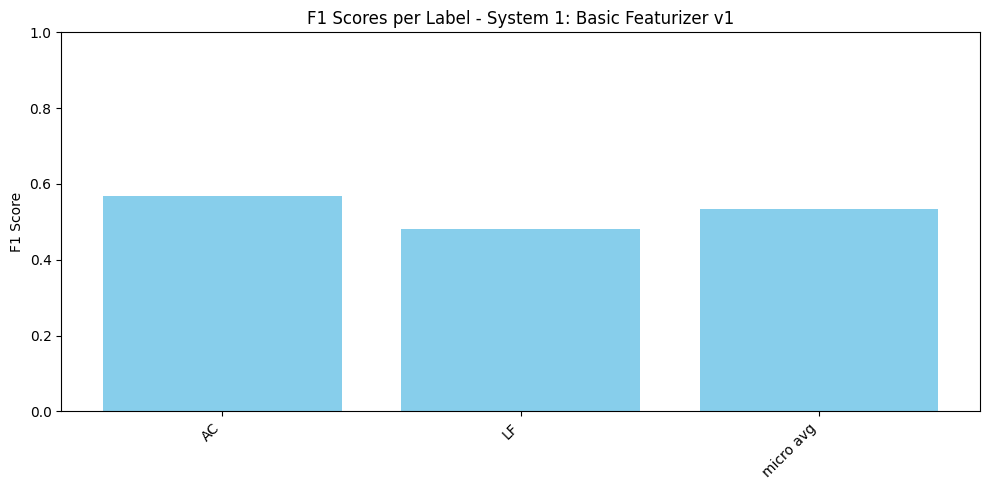


=== Validation Set Classification Report ===
              precision    recall  f1-score   support

          AC       0.76      0.78      0.77       508
          LF       0.51      0.41      0.45       306

   micro avg       0.68      0.64      0.66       814
   macro avg       0.64      0.59      0.61       814
weighted avg       0.67      0.64      0.65       814


=== Test Set Classification Report ===
              precision    recall  f1-score   support

          AC       0.74      0.78      0.76       797
          LF       0.56      0.44      0.50       482

   micro avg       0.68      0.66      0.67      1279
   macro avg       0.65      0.61      0.63      1279
weighted avg       0.67      0.66      0.66      1279



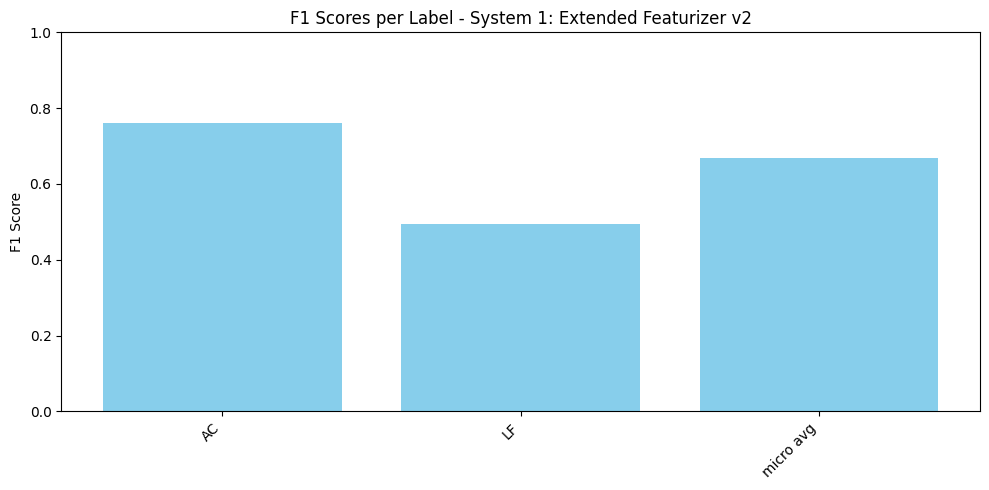

In [ ]:
# Variation 1: Basic Features
def basic_featurizer_v1(sent):
    return [{'word': word.lower(), 'suffix3': word[-3:].lower()} for word in sent]

# Variation 2: Extended Features
def basic_featurizer_v2(sent):
    return [{
        'word': word.lower(),
        'prefix3': word[:3].lower(),
        'suffix3': word[-3:].lower(),
        'is_cap': word[0].isupper(),
        'is_no_cap': word[0].islower()
    } for word in sent]

# Initialize model
sys1_crf = CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=0.01,
    max_iterations=200,
    linesearch='StrongBacktracking',
    all_possible_transitions=True
)

# Run for both feature variations
run_crf_pipeline(
    basic_featurizer_v1,
    sys1_crf,
    dataset,
    train_data,
    val_data,
    test_data,
    model_path=CRF1_MODEL_PATH,
    variation_name="System 1: Basic Featurizer v1"
)

run_crf_pipeline(
    basic_featurizer_v2,
    sys1_crf,
    dataset,
    train_data,
    val_data,
    test_data,
    model_path=CRF1_MODEL_PATH,
    variation_name="System 1: Extended Featurizer v2"
)

# System 2: Advanced Feature Extraction with CRF

---

### Feature Extractors:

- **`advanced_featurizer_v1`**:  
  Extracts rich lexical features without incorporating POS tags, including:  
  - Word-level common features (stemming, orthographic cues)  
  - Bigram and trigram contextual features  

- **`advanced_featurizer_v2`**:  
  Extends `advanced_featurizer_v1` by adding detailed Part-of-Speech (POS) features:  
  - Current, previous, and next POS tags  
  - POS trigram feature to capture syntactic patterns

Both featurizers leverage NLTK’s POS tagging and n-gram extraction to boost the CRF’s contextual understanding.

---

### Model Configuration:

- **Algorithm:** L-BFGS optimizer  
- **Regularization:** c1=0.5 (L1), c2=0.01 (L2)  
- **Max iterations:** 200  
- **Line search:** StrongBacktracking  
- **Transitions:** All possible transitions enabled for sequence modeling


=== Validation Set Classification Report ===
              precision    recall  f1-score   support

          AC       0.83      0.76      0.79       508
          LF       0.67      0.64      0.65       306

   micro avg       0.77      0.72      0.74       814
   macro avg       0.75      0.70      0.72       814
weighted avg       0.77      0.72      0.74       814


=== Test Set Classification Report ===
              precision    recall  f1-score   support

          AC       0.85      0.80      0.82       797
          LF       0.71      0.67      0.69       482

   micro avg       0.79      0.75      0.77      1279
   macro avg       0.78      0.73      0.76      1279
weighted avg       0.79      0.75      0.77      1279



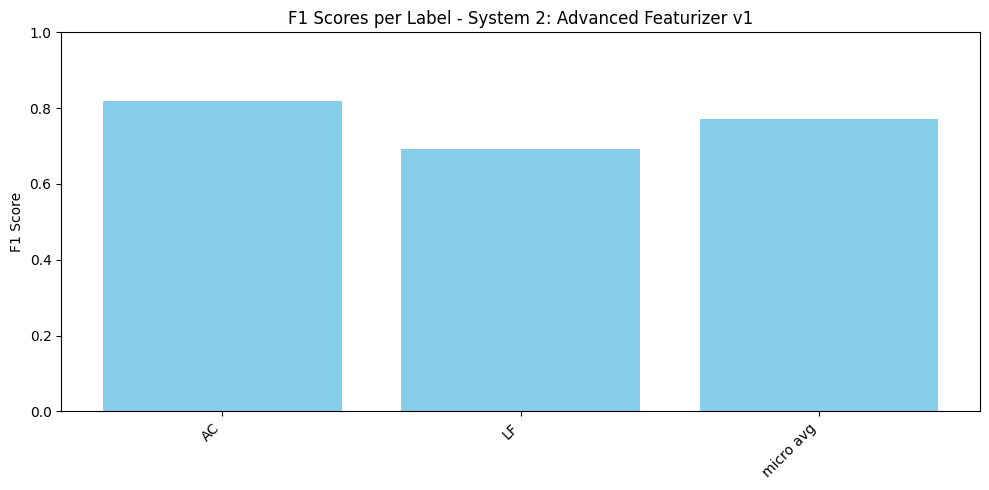


=== Validation Set Classification Report ===
              precision    recall  f1-score   support

          AC       0.82      0.81      0.82       508
          LF       0.63      0.65      0.64       306

   micro avg       0.75      0.75      0.75       814
   macro avg       0.73      0.73      0.73       814
weighted avg       0.75      0.75      0.75       814


=== Test Set Classification Report ===
              precision    recall  f1-score   support

          AC       0.83      0.84      0.84       797
          LF       0.71      0.69      0.70       482

   micro avg       0.79      0.78      0.79      1279
   macro avg       0.77      0.77      0.77      1279
weighted avg       0.79      0.78      0.79      1279



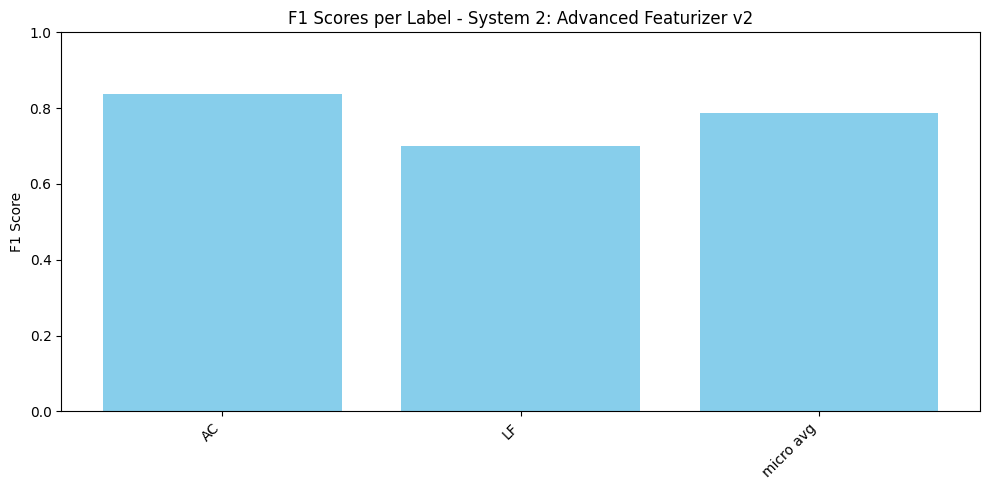

In [ ]:
def advanced_featurizer_v1(sent):
    """
    Feature extractor without POS tagging.

    :param sent: List of words in the sentence.
    :return: List of feature dictionaries for each word.
    """
    bigrams = list(ngrams(sent, 2))
    trigrams = list(ngrams(sent, 3))
    features = [extract_common_features(sent, i, bigrams, trigrams) for i in range(len(sent))]
    return features

def advanced_featurizer_v2(sent):
    """
    Feature extractor with POS tagging.

    :param sent: List of words in the sentence.
    :return: List of feature dictionaries for each word.
    """
    pos_tags = pos_tag(sent)
    bigrams = list(ngrams(sent, 2))
    trigrams = list(ngrams(sent, 3))
    features = []
    for i in range(len(sent)):
        feature = extract_common_features(sent, i, bigrams, trigrams)
        # Add POS features
        current_pos = pos_tags[i][1]
        prev_pos = pos_tags[i-1][1] if i > 0 else '<START_POS>'
        next_pos = pos_tags[i+1][1] if i < len(sent)-1 else '<END_POS>'
        feature.update({
            'pos': current_pos,
            'prev_pos': prev_pos,
            'next_pos': next_pos,
            'pos_trigram': f"{prev_pos}_{current_pos}_{next_pos}",
        })
        features.append(feature)
    return features

# Initialize model
sys2_crf = CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=0.01,
    max_iterations=200,
    linesearch='StrongBacktracking',
    all_possible_transitions=True
)

run_crf_pipeline(
    advanced_featurizer_v1,
    sys2_crf,
    dataset,
    train_data,
    val_data,
    test_data,
    model_path=CRF2_MODEL_PATH,
    variation_name="System 2: Advanced Featurizer v1"
)

run_crf_pipeline(
    advanced_featurizer_v2,
    sys2_crf,
    dataset,
    train_data,
    val_data,
    test_data,
    model_path=CRF2_MODEL_PATH,
    variation_name="System 2: Advanced Featurizer v2"
)

# System 3: BERT + FFNN

---

### Overview

**System 3** integrates the **Bidirectional Encoder Representations from Transformers (BERT)** with a **Feedforward Neural Network (FFNN)** to perform token-level classification tasks, such as Named Entity Recognition (NER). This architecture leverages BERT's deep contextual embeddings, which capture rich semantic and syntactic information from text, and combines them with the expressive power of a feedforward network to make final predictions.

---

### Model Components

- **BERT (Bidirectional Encoder Representations from Transformers):**
  - Utilizes a transformer-based architecture to generate contextual embeddings for each token in the input sequence.
  - Pre-trained on large corpora, BERT captures intricate language patterns and relationships.
  - Fine-tuned on specific tasks to adapt its representations for downstream applications.

- **Feedforward Neural Network (FFNN):**
  - Comprises one or more fully connected layers.
  - Takes BERT's output embeddings as input and produces logits corresponding to each token's class label.
  - Typically includes activation functions like ReLU and softmax for classification tasks.

---

### Workflow

1. **Tokenization:** Input text is split into tokens using a tokenizer compatible with BERT, such as `BertTokenizerFast`.

2. **Embedding Generation:** Tokens are passed through BERT to obtain contextual embeddings.

3. **Classification:** The embeddings are fed into the FFNN, which outputs class probabilities for each token.

4. **Prediction:** The class with the highest probability is assigned to each token.

---

### Model Configuration

- **Optimizer:** AdamW
- **Learning Rate:** 5e-5
- **Epochs:** 3
- **Batch Size:** 16
- **Scheduler:** Linear warmup with no warmup steps
- **Evaluation Metric:** F1-score (calculated using the `seqeval` library)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train 1:   0%|          | 0/125 [00:00<?, ?it/s]

Eval Validation 1:   0%|          | 0/10 [00:00<?, ?it/s]

Train 2:   0%|          | 0/125 [00:00<?, ?it/s]

Eval Validation 2:   0%|          | 0/10 [00:00<?, ?it/s]

Train 3:   0%|          | 0/125 [00:00<?, ?it/s]

Eval Validation 3:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Validation 0:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Test 0:   0%|          | 0/16 [00:00<?, ?it/s]

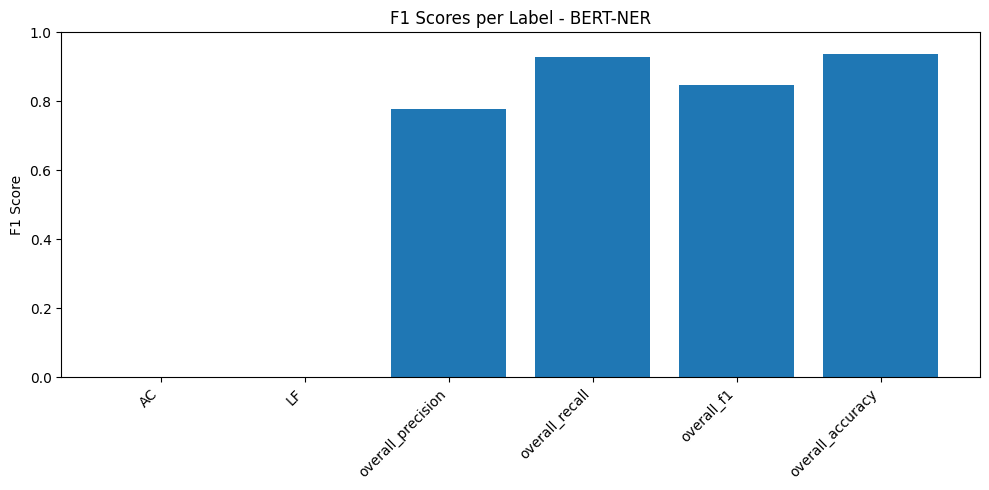

Predicting:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# Epoch handlers and prediction logging
def train_epoch(model, loader, optimizer, scheduler, device, epoch):
    model.train()
    total_loss = 0.0
    logger.info(f"Starting training epoch {epoch}...")
    for batch in tqdm(loader, desc=f"Train {epoch}"):
        batch = {k: v.to(device) for k, v in batch.items()}
        loss = model(**batch).loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    avg_loss = total_loss / len(loader)
    logger.info(f"Epoch {epoch} Training complete. Avg Loss: {avg_loss:.4f}")
    return avg_loss


def eval_model(model, loader, metric, device, id_to_label, epoch, dataset_name="Validation"):
    model.eval()
    preds, refs = [], []
    logger.info(f"Starting evaluation on {dataset_name} set (epoch {epoch})...")
    for batch in tqdm(loader, desc=f"Eval {dataset_name} {epoch}"):
        batch = {k: v.to(device) for k, v in batch.items()}
        logits = model(**batch).logits
        pred_ids = torch.argmax(logits, axis=-1).cpu().numpy()
        true_ids = batch['labels'].cpu().numpy()
        for p_seq, t_seq in zip(pred_ids, true_ids):
            p_tags, t_tags = [], []
            for pid, tid in zip(p_seq, t_seq):
                if tid != -100:
                    p_tags.append(id_to_label[pid])
                    t_tags.append(id_to_label[tid])
            preds.append(p_tags)
            refs.append(t_tags)
    # === DEBUG SAMPLE ===
    logger.info("Sample true tags: %s", refs[0][:20])
    logger.info("Sample pred tags: %s", preds[0][:20])
    # ====================
    results = metric.compute(predictions=preds, references=refs)
    logger.info(f"{dataset_name} Results (epoch {epoch}): {results}")
    return results


def plot_f1_scores(report_dict, variation_name):
    labels, f1_scores = [], []
    for label, metrics in report_dict.items():
        if label in ("accuracy", "macro avg", "weighted avg"):
            continue
        if isinstance(metrics, dict):
            f1 = metrics.get("f1-score", 0.0)
        else:
            f1 = float(metrics)
        labels.append(label)
        f1_scores.append(f1)
    if not labels:
        logger.warning("No labels found to plot F1 scores.")
        return
    logger.info(f"Plotting F1 scores for variation: {variation_name}")
    x = np.arange(len(labels))
    plt.figure(figsize=(10, 5))
    plt.bar(x, f1_scores)
    plt.xticks(x, labels, rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.title(f'F1 Scores per Label - {variation_name}')
    plt.ylabel('F1 Score')
    plt.tight_layout()
    plt.show()


def predict_and_log(model, tokenizer, loader, device, id_to_label, log_path):
    """Generate predictions and save them to a JSONL log."""
    ensure_dir_exists(log_path)
    logger.info(f"Saving predictions to {log_path}...")
    with open(log_path, 'w') as fw:
        for batch in tqdm(loader, desc="Predicting"):
            # extract inputs
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            # forward
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pred_ids = torch.argmax(outputs.logits, axis=-1).cpu().numpy()
            # write per sample
            for tok_ids, p_seq in zip(input_ids.cpu().numpy(), pred_ids):
                words = tokenizer.convert_ids_to_tokens(tok_ids)
                labels = [id_to_label[i] for i in p_seq[:len(words)]]
                record = {'tokens': words, 'predictions': labels}
                fw.write(json.dumps(record) + ' ')
                logger.info("Finished saving predictions.")

# Pipeline functions
def setup_environment():
    logger.info("Disabling tokenizer parallelism and detecting device...")
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Using device: {device}")
    return device


def load_data(dataset_name="surrey-nlp/PLOD-CW-25"):
    logger.info(f"Loading dataset: {dataset_name}...")
    raw_ds = load_dataset(dataset_name)
    logger.info(f"Loaded splits: {list(raw_ds.keys())}")
    return raw_ds


def build_label_mappings(raw_ds):
    logger.info("Building label mappings from training split...")
    all_tags = set(tag for tags in raw_ds["train"]["ner_tags"] for tag in tags)
    label_list = sorted(all_tags)
    label_to_id = {lbl: idx for idx, lbl in enumerate(label_list)}
    id_to_label = {idx: lbl for lbl, idx in label_to_id.items()}
    logger.info(f"Number of labels: {len(label_list)}")
    return label_list, label_to_id, id_to_label


def init_model_tokenizer(num_labels, id_to_label, label_to_id, device):
    logger.info("Initializing tokenizer and model...")
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")
    model = BertForTokenClassification.from_pretrained(
        "bert-base-cased",
        num_labels=num_labels,
        id2label=id_to_label,
        label2id=label_to_id
    )
    model.to(device)
    logger.info("Model and tokenizer ready and moved to device.")
    return tokenizer, model


def tokenize_and_align_labels(tokenizer, label_to_id, max_length=128):
    def fn(examples):
        tokenized = tokenizer(
            examples["tokens"], truncation=True,
            is_split_into_words=True, max_length=max_length,
            return_token_type_ids=False
        )
        labels = []
        for i, tags in enumerate(examples["ner_tags"]):
            word_ids = tokenized.word_ids(batch_index=i)
            prev = None
            lab_ids = []
            for wid in word_ids:
                if wid is None:
                    lab_ids.append(-100)
                elif wid != prev:
                    lab_ids.append(label_to_id[tags[wid]])
                else:
                    lab_ids.append(-100)
                prev = wid
            labels.append(lab_ids)
        tokenized["labels"] = labels
        return tokenized
    return fn


def preprocess(raw_ds, tokenizer, label_to_id):
    logger.info("Tokenizing and aligning labels...")
    ds = raw_ds.map(
        tokenize_and_align_labels(tokenizer, label_to_id), batched=True,
        remove_columns=raw_ds["train"].column_names
    )
    if "token_type_ids" in ds["train"].column_names:
        ds = ds.remove_columns("token_type_ids")
    ds.set_format("torch")
    logger.info(f"Preprocessed. Columns: {ds['train'].column_names}")
    return ds


def create_dataloaders(ds, tokenizer, batch_size=16):
    logger.info("Creating dataloaders with dynamic padding...")
    collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
    train_loader = DataLoader(ds["train"], batch_size=batch_size,
                              shuffle=True, collate_fn=collator)
    val_loader   = DataLoader(ds["validation"], batch_size=batch_size,
                              collate_fn=collator)
    test_loader  = DataLoader(ds["test"], batch_size=batch_size,
                              collate_fn=collator)
    logger.info(f"Batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")
    return train_loader, val_loader, test_loader


def run_bert_pipeline(variation_name="BERT-NER"):
    logger.info(f"Running BERT pipeline: {variation_name}")
    device = setup_environment()
    raw_ds = load_data()
    label_list, label_to_id, id_to_label = build_label_mappings(raw_ds)
    tokenizer, model = init_model_tokenizer(len(label_list), id_to_label, label_to_id, device)
    ds = preprocess(raw_ds, tokenizer, label_to_id)
    train_loader, val_loader, test_loader = create_dataloaders(ds, tokenizer)

    optimizer = AdamW(model.parameters(), lr=5e-5)
    total_steps = 3 * len(train_loader)
    scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    metric = evaluate.load("seqeval", scheme="IOB2", labels=label_list)

    for epoch in range(1, 4):
        train_epoch(model, train_loader, optimizer, scheduler, device, epoch)
        eval_model(model, val_loader, metric, device, id_to_label, epoch, dataset_name="Validation")

    # Evaluate on validation and test sets
    val_report = eval_model(model, val_loader, metric, device, id_to_label, epoch=0, dataset_name="Validation")
    test_report = eval_model(model, test_loader, metric, device, id_to_label, epoch=0, dataset_name="Test")

    # Visualization of test results
    plot_f1_scores(test_report, variation_name)

    predict_and_log(model, tokenizer, val_loader, device, id_to_label, LOG_PATH)
    save_model(model, BERT_MODEL_PATH)
    logger.info("BERT pipeline completed.")

if __name__ == "__main__":
    run_bert_pipeline()


# CRF Model Inference and Interactive UI with Logging

---

### 1. Load Trained Model

---

### 2. Prediction and Logging Function

- **`predict_tags(text)`**:  
  - Tokenizes input text.  
  - Extracts features using `advanced_featurizer_v2`.  
  - Predicts NER tags with the loaded CRF model.  
  - Measures latency in milliseconds.  
  - Logs prediction metadata (timestamp, input, tags, latency) to a JSON lines file.  
  - Returns token-tag pairs along with latency info.  
  - Handles exceptions gracefully.
---

### 3. Logs-View Endpoint

- Returns the last 20 lines from the prediction log file.  
- Returns a default message if no logs exist.
---

### 4. Build Gradio Interfaces

- **Tagger UI:** Text input → Token-Tag pairs + latency output  
- **Logs UI:** Displays recent prediction logs  
- Tabbed layout for switching between interfaces.

In [ ]:
import time, os, json
import joblib
import gradio as gr
from fastapi import FastAPI, Request
from threading import Thread
import uvicorn

# Load the pre-trained CRF model
model = joblib.load(CRF1_MODEL_PATH)

def predict_tags(text: str):
    """
    Predicts NER tags for a given input text using the CRF model.
    Logs the prediction along with latency and timestamp.

    Args:
        text (str): Input sentence for NER tagging.

    Returns:
        tuple: List of (token, predicted_tag) and latency string in ms.
    """
    try:
        start_time = time.time()
        tokens = text.split()
        features = advanced_featurizer_v2(tokens)
        tags = model.predict_single(features)
        latency_ms = int((time.time() - start_time) * 1000)

        log_entry = {
            "timestamp": time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime()),
            "input": text,
            "prediction": tags,
            "latency_ms": latency_ms
        }
        os.makedirs(os.path.dirname(LOG_PATH), exist_ok=True)
        with open(LOG_PATH, 'a') as log_file:
            log_file.write(json.dumps(log_entry) + "\n")

        return list(zip(tokens, tags)), f"{latency_ms} ms"
    except Exception as e:
        return [["ERROR", str(e)]], "Prediction failed"

def view_logs():
    """
    Retrieves the last 20 lines from the prediction log file.

    Returns:
        str: Concatenated last 20 log entries or a default message.
    """
    if not os.path.exists(LOG_PATH):
        return "No logs yet."
    with open(LOG_PATH, 'r') as log_file:
        last_logs = log_file.readlines()[-20:]
    return "".join(last_logs)

# Define Gradio UI interfaces
tagger_ui = gr.Interface(
    fn=predict_tags,
    inputs=gr.Textbox(lines=2, placeholder="Enter text here…"),
    outputs=[gr.Dataframe(headers=["Token", "NER Tag"]), gr.Text()],
    title="CRF Sequence Tagger"
)

logs_ui = gr.Interface(
    fn=view_logs,
    inputs=[],
    outputs=gr.Textbox(lines=20, label="Recent Logs"),
    title="View Prediction Logs"
)

# Launch the app with tabbed interface
gr.TabbedInterface([tagger_ui, logs_ui], ["Tag Text", "View Logs"]) \
  .launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
IMPORTANT: You are using gradio version 3.45.0, however version 4.44.1 is available, please upgrade.
--------
IMPORTANT: You are using gradio version 3.45.0, however version 4.44.1 is available, please upgrade.
--------
IMPORTANT: You are using gradio version 3.45.0, however version 4.44.1 is available, please upgrade.
--------
Running on public URL: https://9187bc69e938780389.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
